# Cut-it

David Alsina, Isabela Cáceres, y Camilo Martinez

En este proyecto la idea es desarrollar un algorithmo de segmentación de imagenes a color, utilizando el Mean  Sift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## Algoritmo de mean-shift

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## Algoritmo basado en grafos.

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu eexplica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

In [1]:
!pip install opencv-python
# apt-get update && apt-get install -y python3-opencv

In [2]:
#para trabajar la imagen :D
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import ndimage

https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/ 


(302388, 3)
(446, 678, 3)


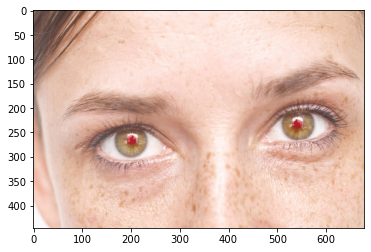

In [3]:
#img = cv2.imread('casitas.jpeg')
img = cv2.imread('eye.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_flat = img.reshape((-1, 3))

print(img_flat.shape)
print(img.shape)
plt.imshow(img);

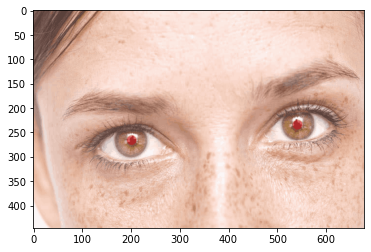

In [4]:
#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 

k = 50
retval, labels, centers = cv2.kmeans(img_flat.astype('float32'), k,
                                     None, criteria,
                                     10, cv2.KMEANS_PP_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((img.shape))
 
plt.imshow(segmented_image)                                     

In [5]:
def gen_window(img: np.ndarray, center: tuple, diameter: int) -> np.ndarray:
    
    """
        Genera lista de indices de filas
        y de columnas que corresponden a la ventana
        (circulo).
    """
    
    # calcula el radio de la imagen
    radious  = diameter//2
    
    # extrae la fila y la columna de la imagen
    row, col = center 
    
    # vector de theta para variar el ángulo
    theta = np.arange(0, 360)*(np.pi/180)

    # columnas 
    y = (radious*np.sin(theta)).astype("int32") 
    
    # filas
    x = (radious*np.cos(theta)).astype("int32") 
    
    
    # posiciona en el centro seleccionado
    # al circulo
    rows = x + (row)
    cols  = y + (col)
       
    # copia la imagen
    img_copy = copy.deepcopy(img)

    # obtiene el numero de elementos en cada vector
    # para recortar el for a la mitad
    nrows = rows.shape[0] 
    ncols = cols.shape[0]
    

    for row_down, row_up, col1, col2 in zip(rows[:nrows//4],
                                            np.flip(rows[nrows//4:nrows//2]),
                                            cols[:ncols//4],
                                            cols[nrows//2:3*ncols//4]):
        
        img_copy[row_up-2:row_down+2, col2-2:col1+2] = 1
    
    
    
    return img_copy

In [6]:
def isolate_window(img: np.ndarray, center: tuple, diameter: int) -> np.ndarray:
    
    return img * gen_window(img = np.zeros(img.shape),
                            center = center,
                            diameter = diameter)


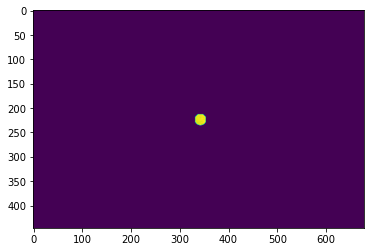

In [7]:
img_ch = img[:,:,0]

# calcula el centro de masa de la imagen
window_center = ndimage.center_of_mass(img_ch)
window_center = tuple(np.floor(window_center).astype(np.int32))

plt.imshow( isolate_window(img = img_ch,
                           center = window_center,
                           diameter = 20) )
plt.show()

In [8]:
def find_modes(img: np.ndarray, diameter: int, ntrials: int):
    
    nrows, ncols = img.shape
    sz = ntrials #np.ceil(np.sqrt(ntrials)).astype("int32") 
    
    rng = np.random.default_rng()
    
    rows = rng.choice(nrows,  sz) 
    cols = rng.choice(ncols, sz)
    print(rows)
    
    #rows = np.arange(0, nrow )
    #cols = np.arange(0, ncols)
    
    centers = {}
    
    for row, col in zip(rows, cols):

        window_center_of_mass = (row, col)
        max_iter = 50
        e_tol = 0.07
        count = 0
        e = 1e5

        while (count <= max_iter) and (e >= e_tol):

            img_window = isolate_window(img_ch,
                                        window_center_of_mass,
                                        diameter = diameter)
            mass_center = ndimage.center_of_mass(img_window)

            e = np.linalg.norm(np.array(window_center_of_mass) - np.array(mass_center))
            #print(e)

            window_center_of_mass = tuple(np.floor(mass_center).astype(np.int32))
            count+=1

        centers[(row,col)] = [window_center_of_mass, e]
    
    return centers

In [16]:
img_ch = segmented_image[:,:,0]
nsamples = int((img.shape[0] * img.shape[1]) * 0.01)+1
print("número de muestras: ", nsamples)

modes = find_modes(img = img_ch, diameter = 60, ntrials = nsamples)

número de muestras:  3024
[184 393   4 ... 234 366 416]


In [17]:
modes.keys()

dict_keys([(184, 144), (393, 539), (4, 98), (208, 254), (373, 110), (209, 492), (182, 593), (131, 14), (31, 13), (361, 245), (395, 201), (408, 210), (444, 67), (111, 426), (441, 89), (410, 472), (172, 109), (22, 470), (20, 663), (248, 15), (337, 644), (327, 450), (236, 648), (118, 259), (165, 528), (416, 174), (36, 383), (84, 487), (200, 105), (88, 521), (207, 592), (72, 74), (140, 363), (204, 581), (365, 431), (394, 116), (70, 549), (280, 288), (239, 196), (424, 669), (354, 404), (201, 260), (33, 468), (191, 567), (362, 671), (188, 432), (397, 578), (273, 645), (432, 367), (359, 475), (415, 127), (370, 302), (73, 450), (164, 159), (313, 658), (137, 542), (49, 619), (114, 16), (25, 564), (425, 386), (439, 452), (35, 181), (224, 640), (374, 408), (70, 348), (241, 624), (97, 373), (407, 66), (176, 105), (407, 275), (437, 561), (439, 613), (200, 108), (119, 595), (358, 19), (190, 131), (169, 18), (200, 499), (247, 364), (43, 192), (118, 44), (194, 206), (106, 520), (193, 553), (396, 422),

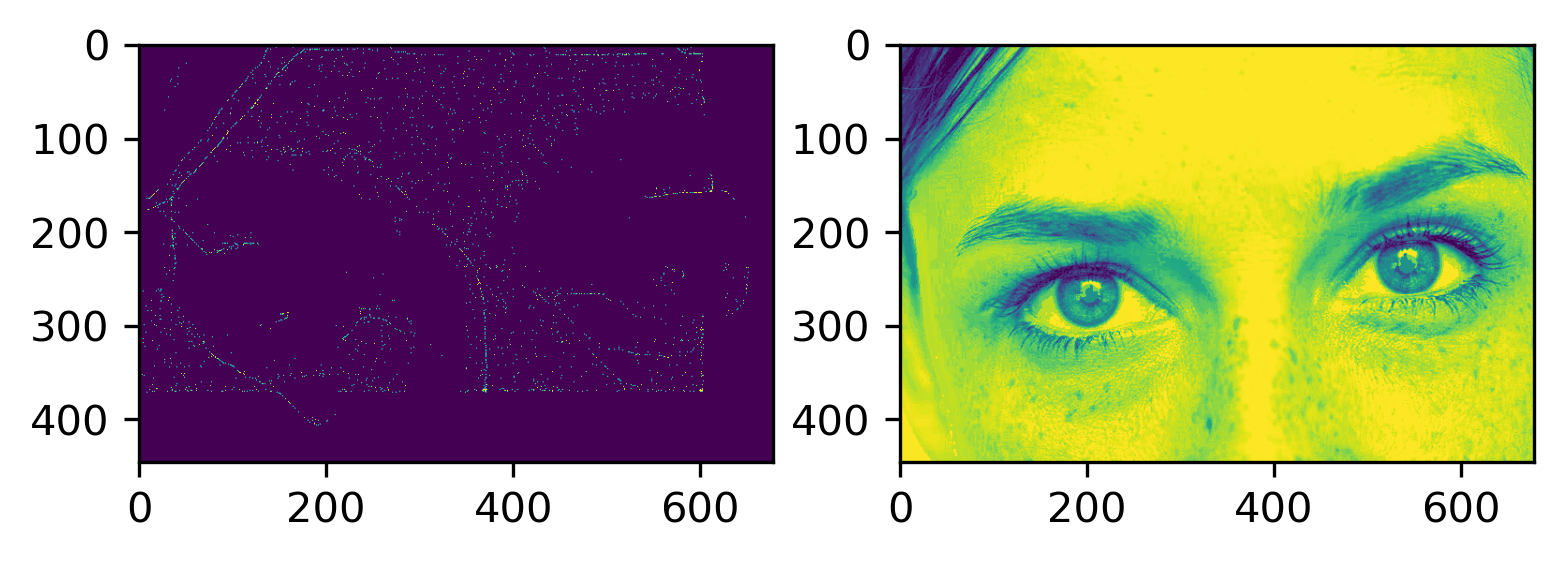

In [18]:
clusters = {}
clusters_centers = np.zeros(img_ch.shape)

for center_of_mass, e  in modes.values():
    
    if center_of_mass not in clusters.keys():
        if (center_of_mass[0] < 0) or (center_of_mass[1]<0):
            continue
            
        clusters[center_of_mass] = 0
        clusters_centers[center_of_mass[0], center_of_mass[1]] = 1
    else: 
        clusters[center_of_mass] += 1
    
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=300)
axs[0].imshow( clusters_centers )
axs[1].imshow( img_ch )
plt.show()

In [12]:

img_ch = img[:,:,0]
diameter = 40

# el centro de la ventana se debe seleccionar de manera aleatoria y probar con varios ???????
window_center_of_mass = ndimage.center_of_mass(img_ch)
window_center_of_mass = tuple(np.floor(window_center_of_mass).astype(np.int32))

print(window_center_of_mass)

max_iter = 50
e_tol = 0.07
count = 0
e = 1e5

while (count <= max_iter) and (e >= e_tol):

    img_window = isolate_window(img_ch,
                                window_center_of_mass,
                                diameter = diameter)
    mass_center = ndimage.center_of_mass(img_window)
    
    e = np.linalg.norm(np.array(window_center_of_mass) - np.array(mass_center))
    #print(e)
    
    window_center_of_mass = tuple(np.floor(mass_center).astype(np.int32))
    count+=1

print(window_center_of_mass)
print(e)

(224, 343)
(173, 292)
0.7163127737213604


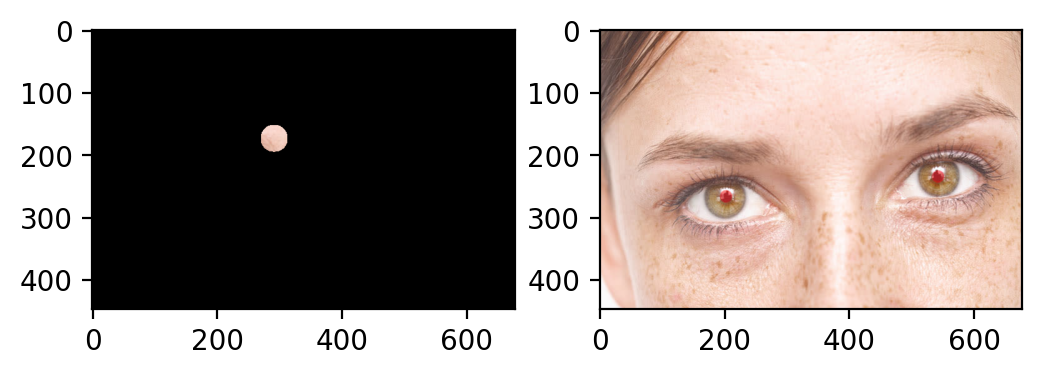

In [13]:
img_a        = copy.deepcopy(img)
img_a[:,:,0] = isolate_window(img = img[:,:,0],
                           center = window_center_of_mass,
                           diameter = 40).astype('uint8')

img_a[:,:,1] = isolate_window(img = img[:,:,1],
                           center = window_center_of_mass,
                           diameter = 40).astype('uint8')

img_a[:,:,2] = isolate_window(img = img[:,:,2],
                           center = window_center_of_mass,
                           diameter = 40).astype('uint8')

fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200)
axs[0].imshow(img_a)
axs[1].imshow(img)
plt.show()

In [14]:
def mean_shift(img, max_iter, e_tol):
    for c in img.shape[2]:
        while (count <= max_iter) and (e >= e_tol):
            pass
             

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=056790ab-bf30-4326-be04-ac26143d53b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>